For a given neuron, we can find out:
1. Number of branch points
2. Branch order distribution

[Universal features of dendrites through centripetal branch ordering](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5515450/)
- Horton-Strahler order (SO): A method developed to characterise branch points in a river
- SO is a centripetal ordering scheme: All terminal branches are assigned order 1. When two branches of order k meet, the parent branch is assigned order k+1. If branches of different orders meet, the larger k is used to determine the SO of the parent.  
- "(Findings that report SO) have little descriptive power if the underlying structure is a binary tree". See: ["Horton's law of stream numbers"](https://pubs.geoscienceworld.org/gsa/gsabulletin/article-abstract/56/3/275/4075/EROSIONAL-DEVELOPMENT-OF-STREAMS-AND-THEIR?redirectedFrom=fulltext) and 
[Statistical inevitability of Horton's laws and the apparent randomness of stream channel networks](https://doi.org/10.1130/0016-7606(1945)56[275:EDOSAT]2.0.CO;2)
- In contrast to Strahler order, centrifugal ordering schemes start from the root and end at the leaves. Order is 0 (or sometimes 1) at the root and increases by one at each branch point


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import exists, expanduser

import sys
from cx_analysis.skeleton_morphology import run_morphology_analysis, find_leaf_nodes
from cx_analysis.connectome import Connectome
from cx_analysis.utils import load_preprocessed_connectome, yymmdd_today
#from cx_analysis.node_ops import segment_skeleton, find_end_points, find_central_segment, measure_path_lengths, measure_seg_distances
from vis.fig_tools import subtype_cm

plt.rcdefaults()
plt.style.use('vis/lamina.mplstyle')

In [3]:
tp = '210615'
C = load_preprocessed_connectome(f"~/Data/{tp}_lamina/")

Pickle loaded from: /mnt/home/nchua/Data/210615_lamina/210615_preprocessed.pickle


In [26]:
results_file = expanduser(f'~/Data/{tp}_lamina/210625_lmc-morphology.json')
lmc_sts = ['LMC_1', 'LMC_2', 'LMC_3', 'LMC_4', 'LMC_N']#, 'LMC_3', 'LMC_4']#, 'LMC_N']#, 'R7', 'R8', 'R7p']
lmc_ids = [s for s, data in C.skel_data.items() if data.subtype in lmc_sts]

if exists(results_file):
    with open(results_file, 'r') as fh:
        d = json.load(fh)
        segments, central_segs, seg_lens, seg_dists, strahler = d['segments'], d['central_segs'], d['seg_lengths'], d['seg_distances'], d['strahler']
else:
    segments, central_segs, seg_lens, seg_dists, strahler = run_morphology_analysis(C, lmc_ids, 
                                                                                    restrict_tags='lamina_end', 
                                                                                    save_file=results_file, 
                                                                                    verbose=False)

In [12]:
summary = []
for s in lmc_ids:
    data = C.skel_data[s]
    n_leaves = find_leaf_nodes(data.skel_nodes)
    summary.append({'name': data.name,
                    'skel_id': data.skel_id,
                    'om': data.group,
                    'subtype': data.subtype,
                    'n_central_nodes': len(central_segs[s]), 
                    'n_nodes': len(data.skel_nodes) - len(data.r_nodes), 
                    'n_segments': len(segments[s]),
                    'n_leaves': len(n_leaves),
                    'total_path_len': sum([v for k, v in seg_lens[s].items()]), 
                    'strahler_num': max([v for k, v in strahler[s].items()])})
    
cell_df = pd.DataFrame(summary).set_index('skel_id')

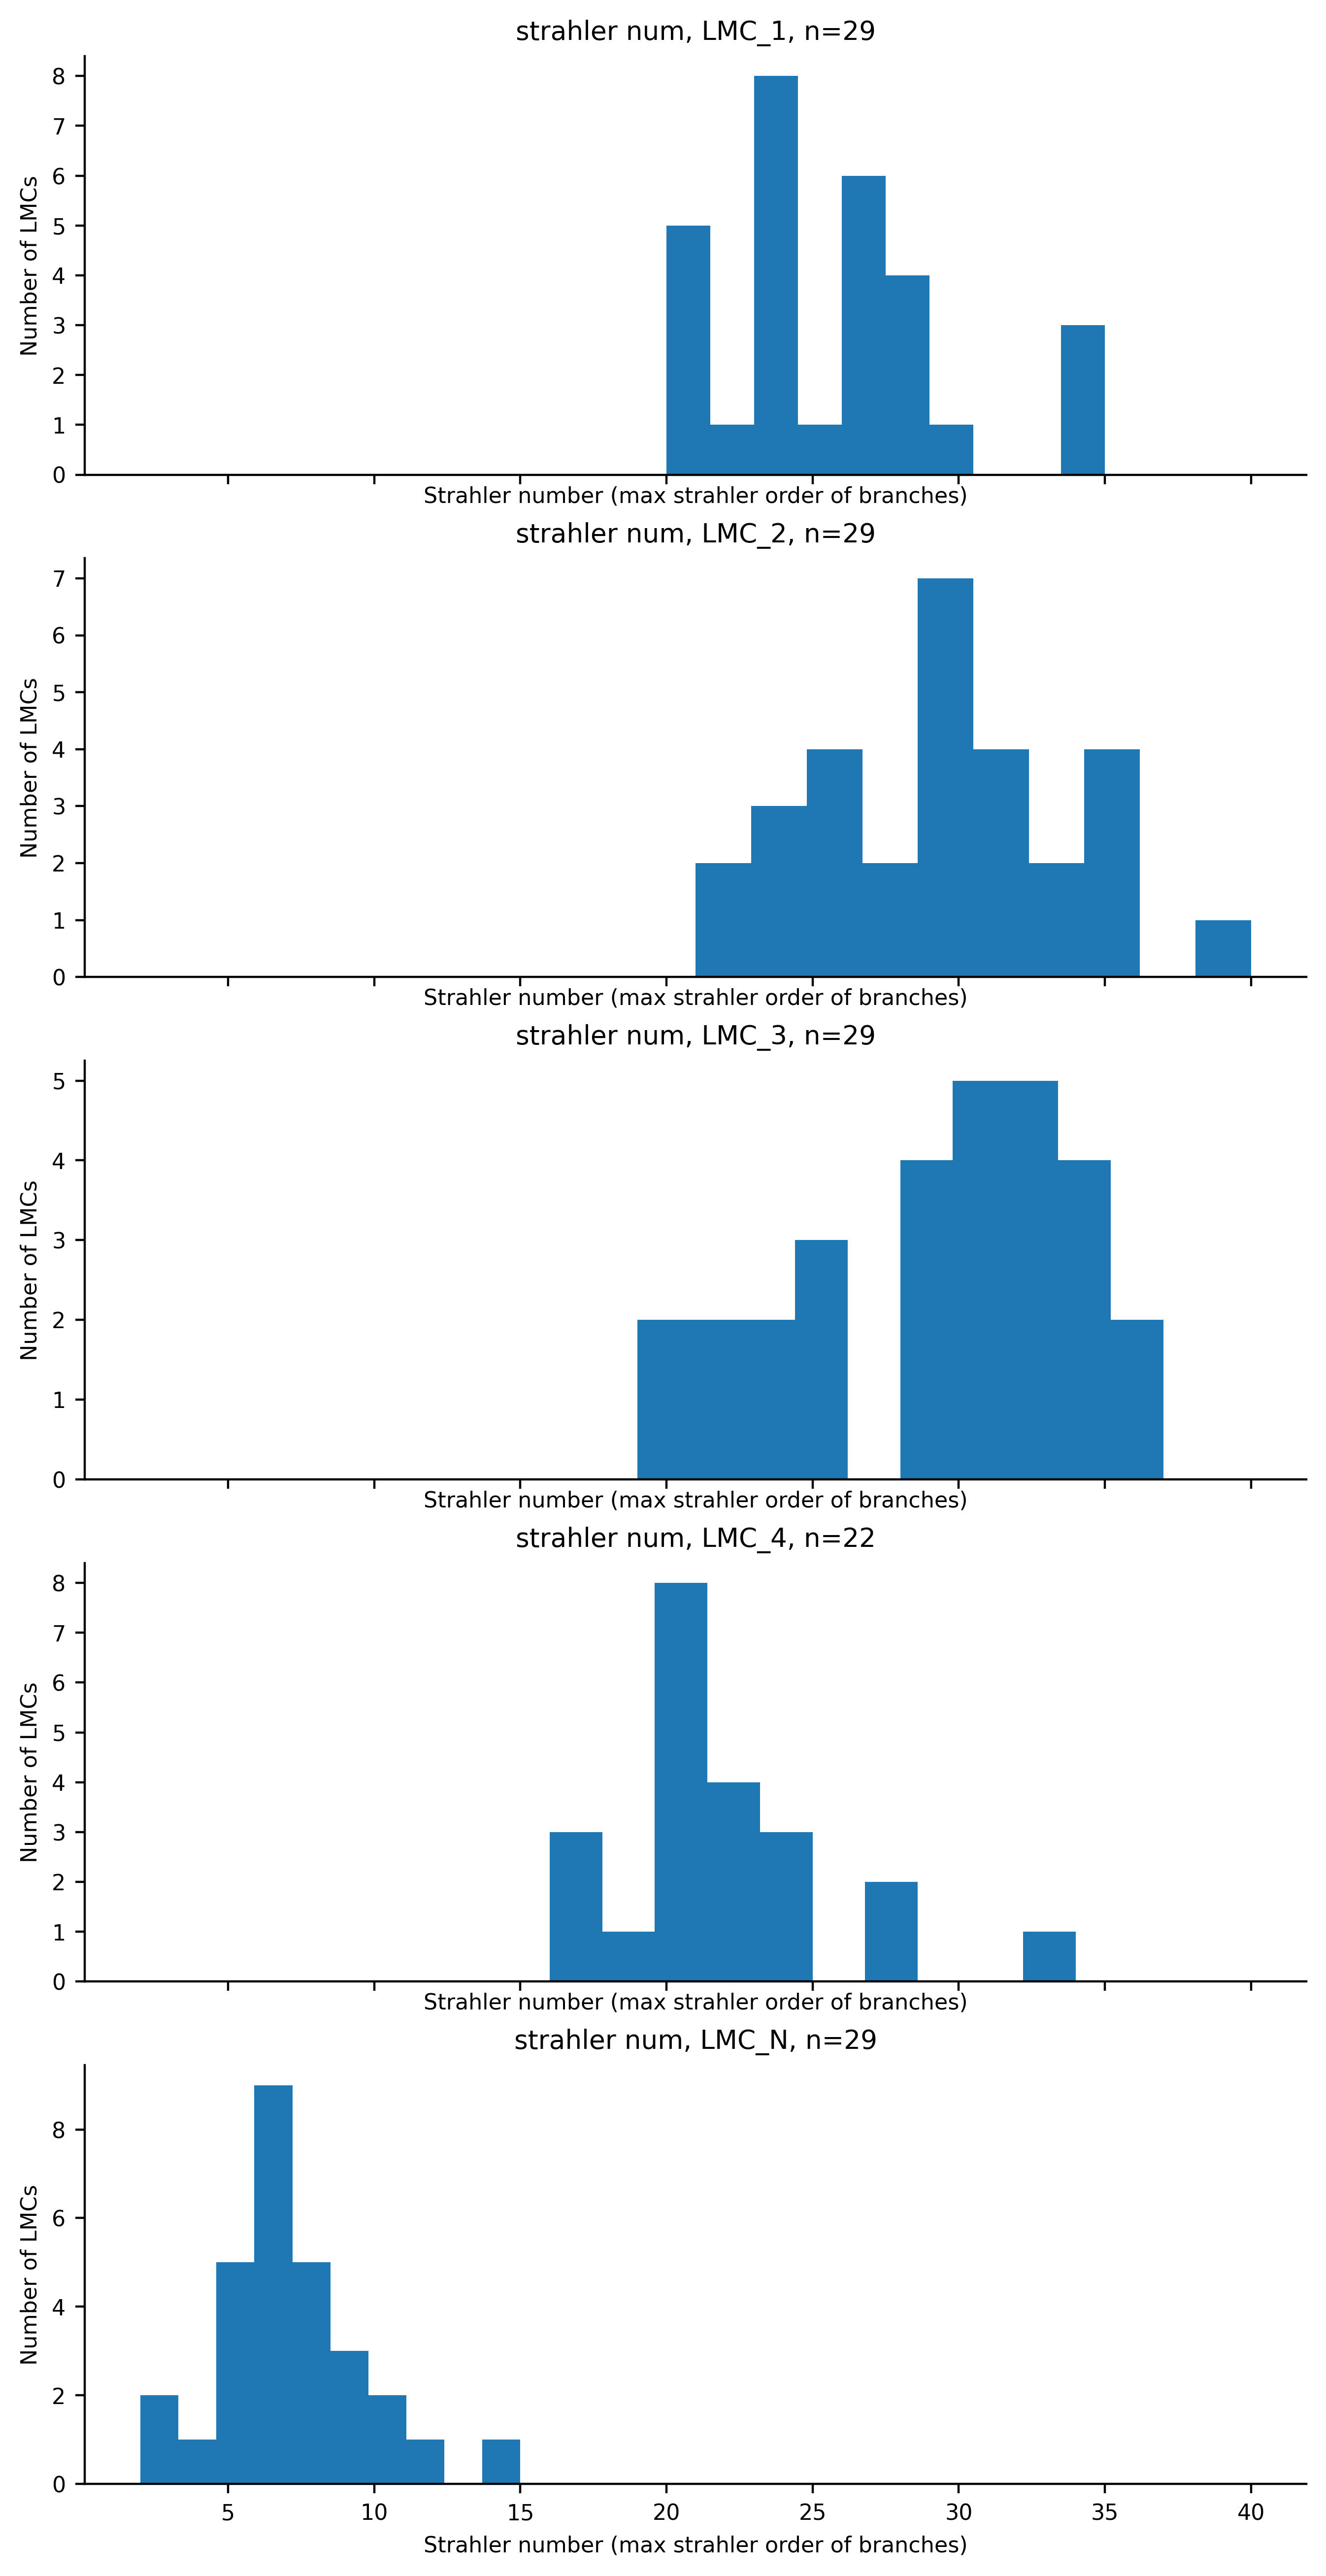

In [13]:
fig, ax = plt.subplots(5, sharex=True, figsize=[8, 16])

i = 0
for st, rows in cell_df.groupby('subtype'):
    ax[i].hist(rows['strahler_num'])
    ax[i].set_title(f"strahler num, {str(st)}, n={len(rows)}")
    
    ax[i].set_xlabel('Strahler number (max strahler order of branches)')
    ax[i].set_ylabel('Number of LMCs')
    i+=1
plt.show()

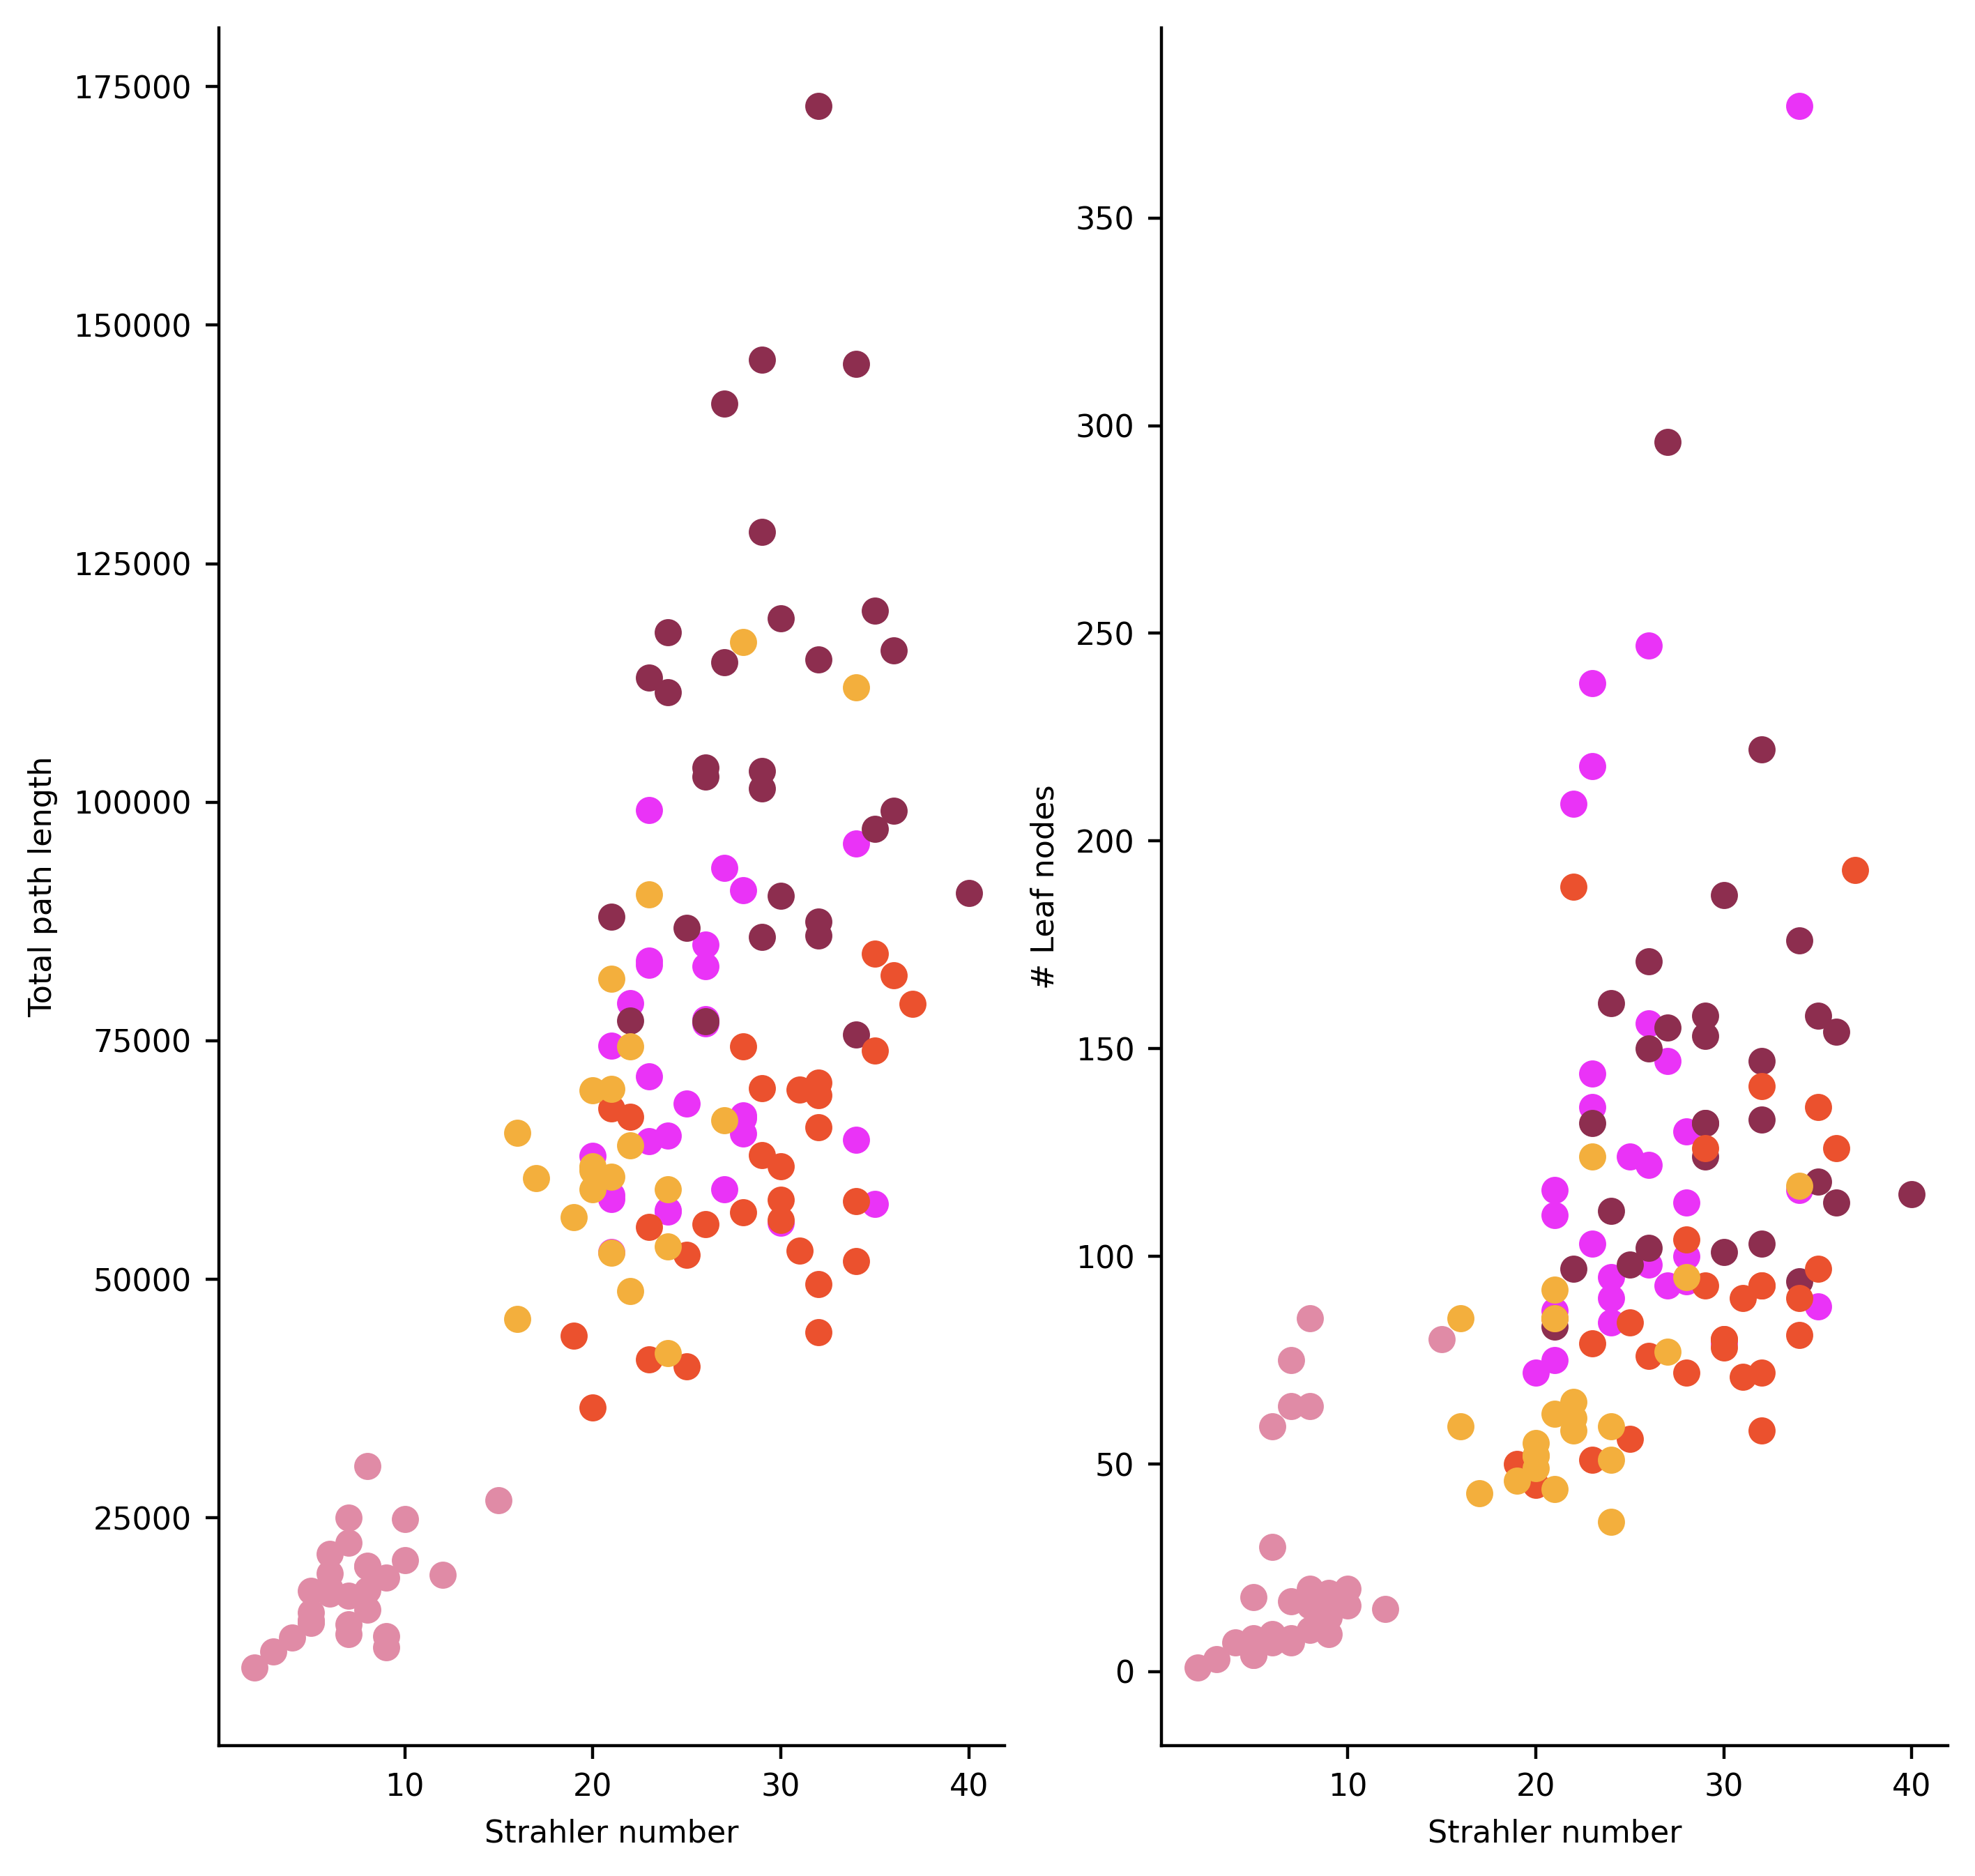

In [14]:
fig, ax = plt.subplots(1, 2, sharex=True, figsize=[8, 8])

cm = subtype_cm()

i = 0
for st, rows in cell_df.groupby('subtype'):
    xdata = []
    ydata0 = []
    ydata1 = []
    for om, rowsrows in rows.groupby('om'):
        xdata.append(rowsrows['strahler_num'])
        #om_total_len = cell_df.loc[cell_df['om'] == str(om), 'total_path_len'].sum()
        ydata0.append(rowsrows['total_path_len'])
        ydata1.append(rowsrows['n_leaves'])
        
        
    ax[0].scatter(xdata, ydata0, c=cm[st])
    ax[1].scatter(xdata, ydata1, c=cm[st])
    #ax.set_title(f"Average strahler num of neuron's segments, {str(st)}, n={len(xdata)}")
    i+=1
ax[0].set_xlabel('Strahler number')
ax[1].set_xlabel('Strahler number')
ax[0].set_ylabel('Total path length')
ax[1].set_ylabel('# Leaf nodes')
plt.show()

In [18]:
seg_data = []
major_seg = []

def div(num: float, denom: float):
    if denom == 0:
        return np.nan
    else:
        return num/denom

for s, segmented in segments.items():
    for seg_ind, seg in segmented.items():
        if int(seg_ind) in central_segs[s]:  # seg_ind = seg[1]
            #print(f"skip {seg_ind}")
            continue
        #elif (int(seg[0]) in central_segs[s]) and strahler[s][str(seg[-1])] == 1:
        elif (str(seg[0]) in central_segs[s]) and (strahler[s][str(seg[-1])] == 1):
            continue
        else:
            strahl_ind = seg[-1]  
            # strahler[s] is indexed by last node of the segment  
            this_seg = {'skel_id': str(s),
                         'name': cell_df.loc[s, 'name'], 
                         'subtype': cell_df.loc[s, 'subtype'],
                         'ind': seg_ind,
                         'dist': seg_dists[s][seg_ind], 
                         'len': seg_lens[s][seg_ind],
                         'tortuosity': div(seg_lens[s][seg_ind], seg_dists[s][seg_ind]), 
                         'strahl_ord': strahler[s][int(strahl_ind)]}
            seg_data.append(this_seg)
            if int(seg[0]) in central_segs[s]:
                major_seg.append(this_seg)

seg_df = pd.DataFrame(seg_data)
major_df = pd.DataFrame(major_seg)

In [19]:
summary = []
for s in lmc_ids:
    data = C.skel_data[s]
    these_segs = seg_df.loc[seg_df['skel_id'] == s]
    n_leaf = ()
    summary.append({'name': data.name,
                    'skel_id': data.skel_id,
                    'om': data.group,
                    'subtype': data.subtype,
                    'total_path_len': these_segs['len'].sum(), 
                    'strahler_num': these_segs['strahl_ord'].max()})
    
cell_df = pd.DataFrame(summary).set_index('skel_id')

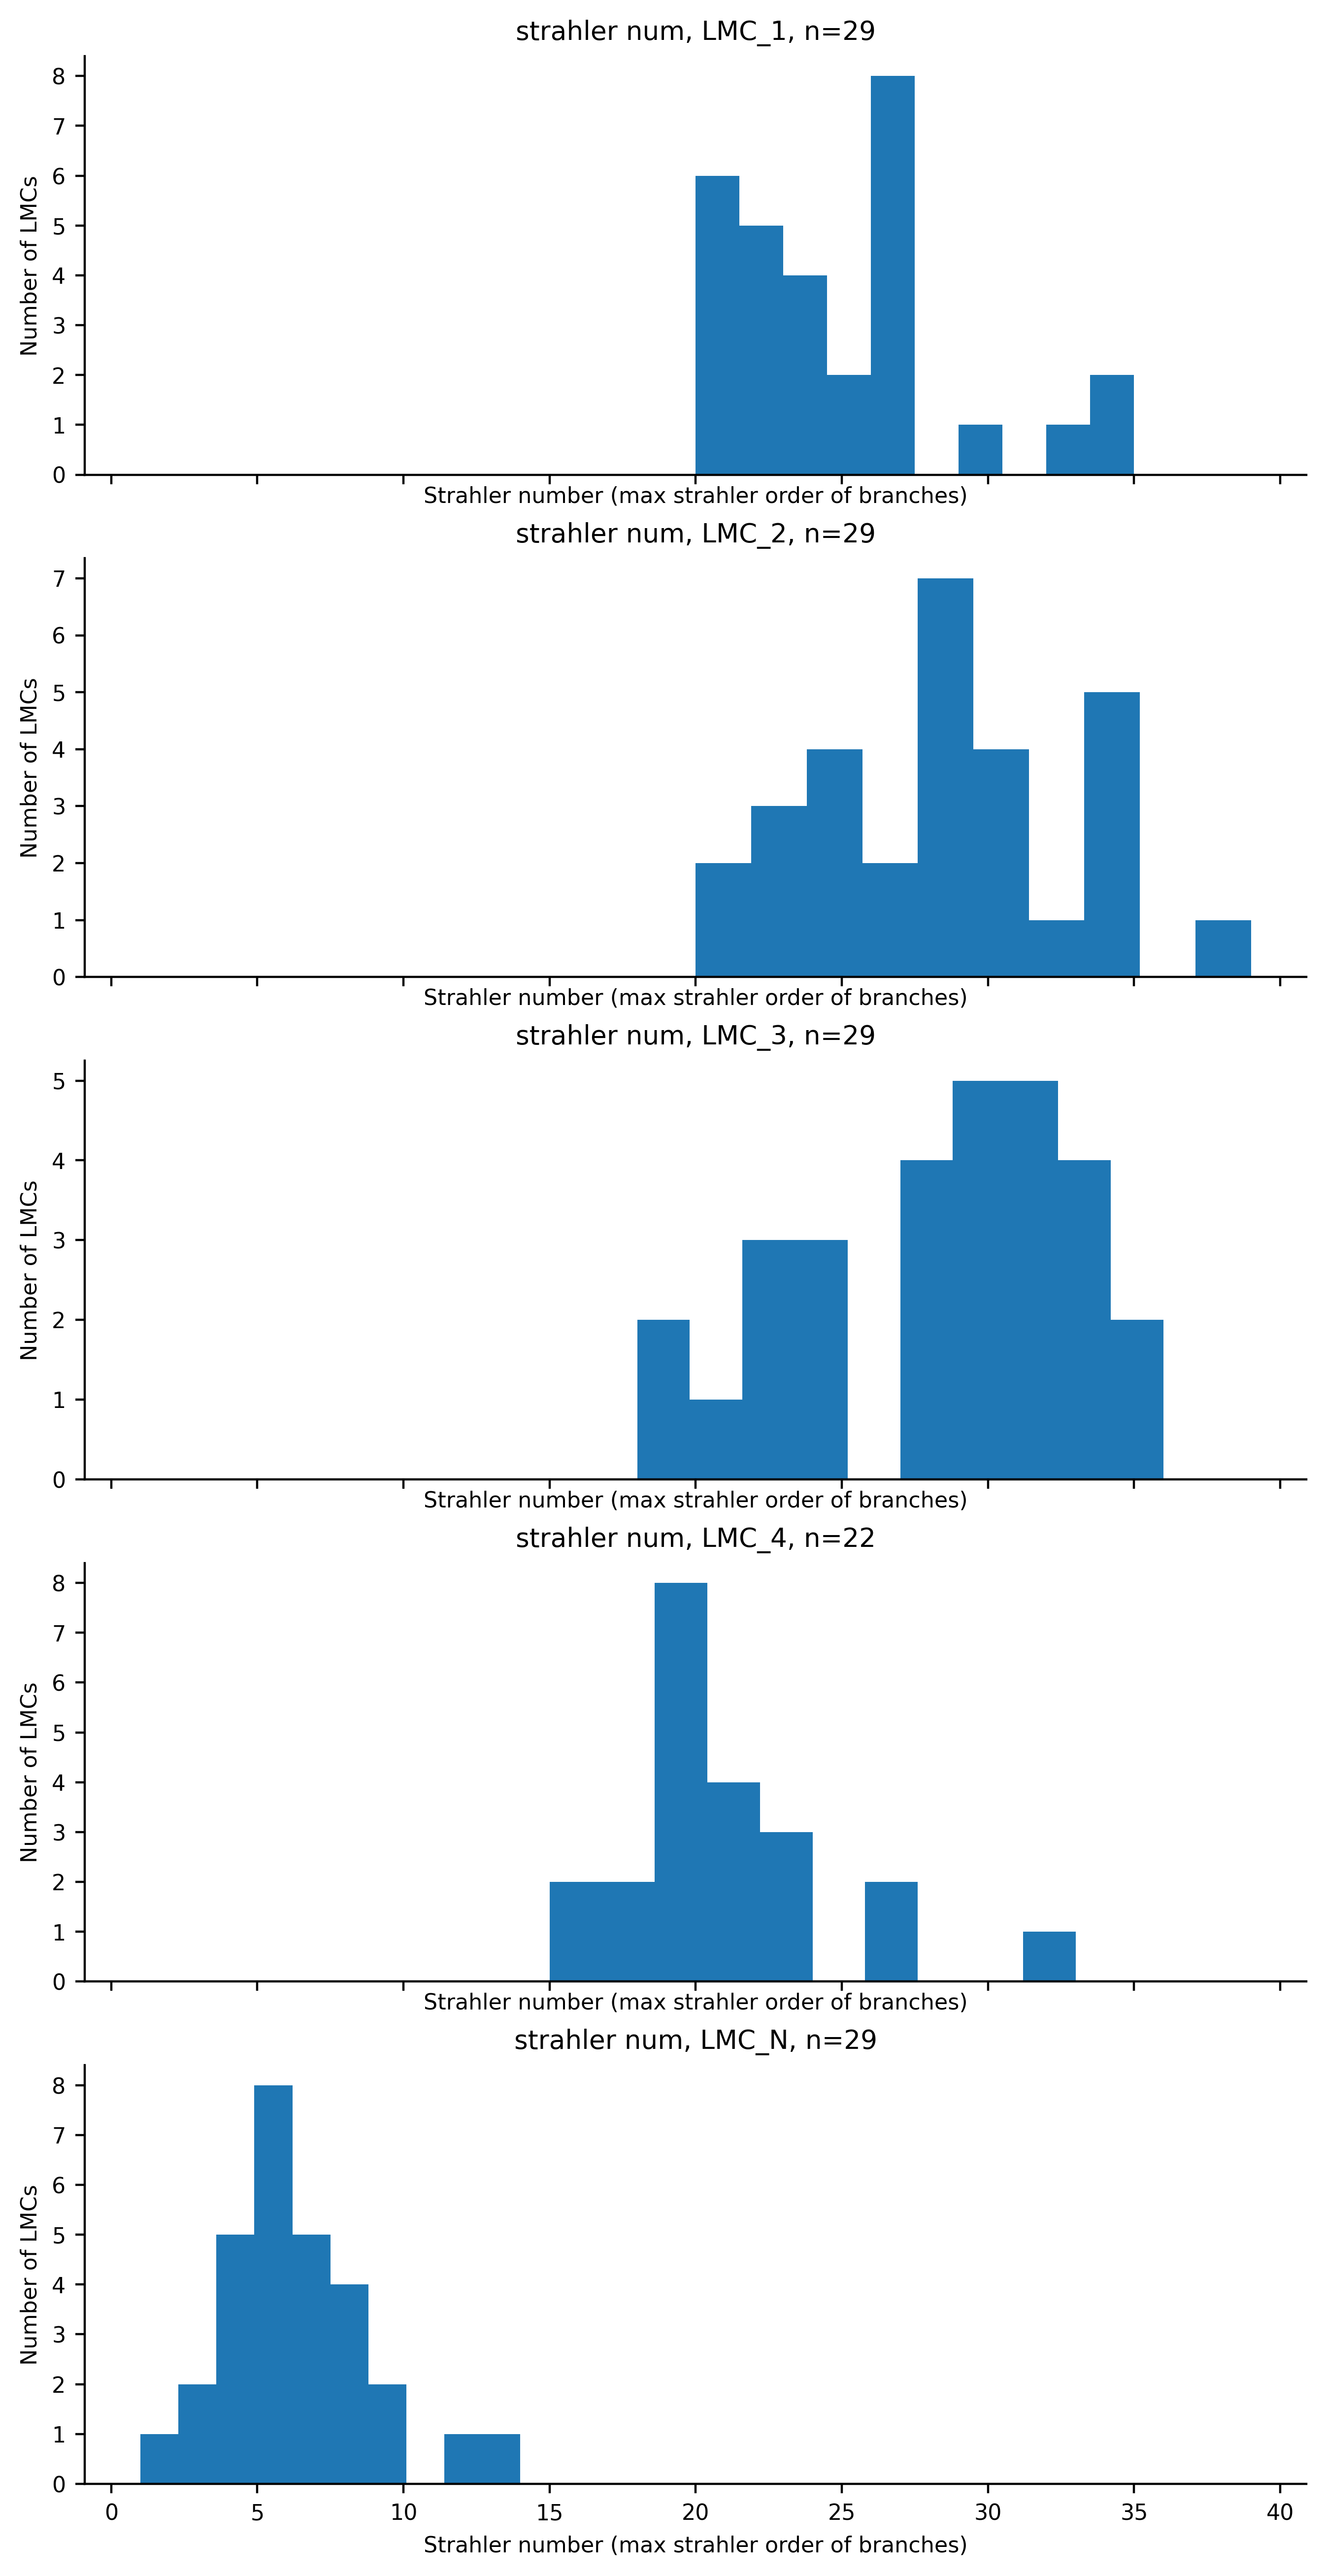

In [20]:
fig, ax = plt.subplots(5, sharex=True, figsize=[8, 16])

i = 0
for st, rows in cell_df.groupby('subtype'):
    ax[i].hist(rows['strahler_num'])
    ax[i].set_title(f"strahler num, {str(st)}, n={len(rows)}")
    
    ax[i].set_xlabel('Strahler number (max strahler order of branches)')
    ax[i].set_ylabel('Number of LMCs')
    i+=1
plt.show()

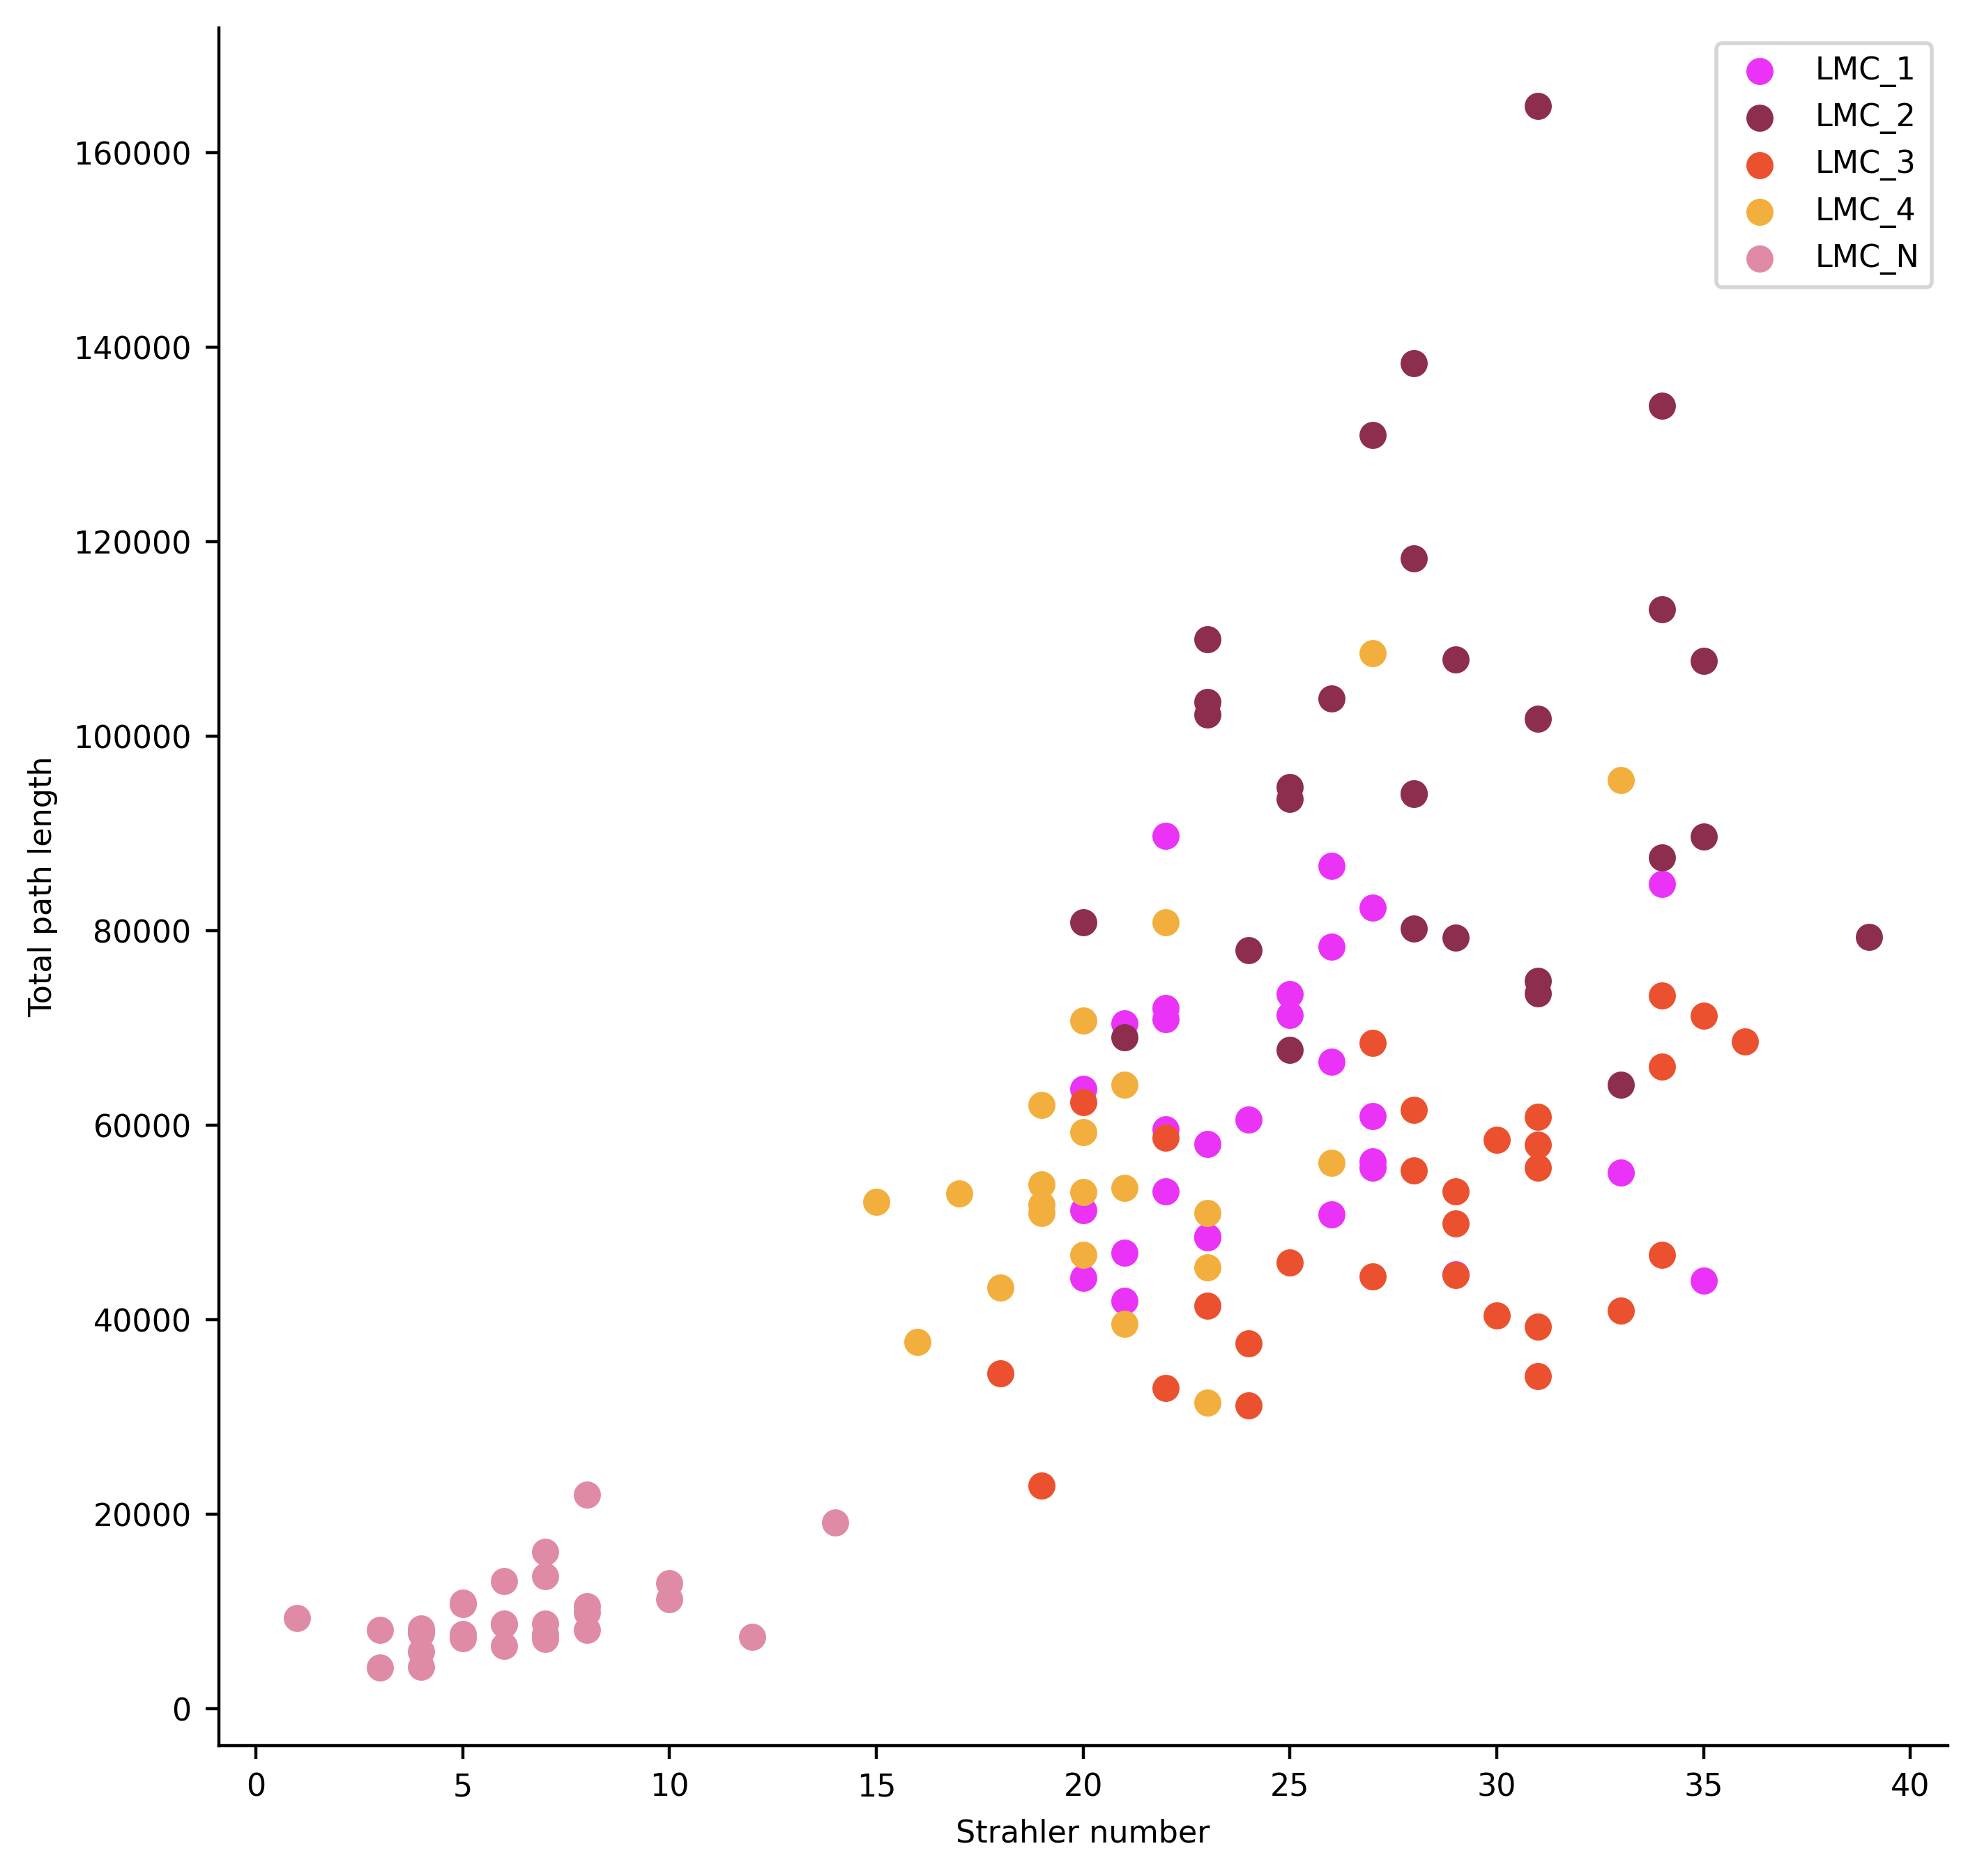

In [22]:
fig, ax = plt.subplots(1, sharex=True, figsize=[8, 8])

cm = subtype_cm()

i = 0
for st, rows in cell_df.groupby('subtype'):
    xdata = []
    ydata0 = []
    ydata1 = []
    for om, rowsrows in rows.groupby('om'):
        xdata.append(rowsrows['strahler_num'])
        #om_total_len = cell_df.loc[cell_df['om'] == str(om), 'total_path_len'].sum()
        ydata0.append(rowsrows['total_path_len'])
        #ydata1.append(rowsrows['n_leaves'])
        
        
    ax.scatter(xdata, ydata0, c=cm[st], label=st)
    #ax[1].scatter(xdata, ydata1, c=cm[st])
    #ax.set_title(f"Average strahler num of neuron's segments, {str(st)}, n={len(xdata)}")
    i+=1
#ax.set_yscale('log')
ax.set_xlabel('Strahler number')
#ax[1].set_xlabel('Strahler number')
ax.set_ylabel('Total path length')
#ax[1].set_ylabel('# Leaf nodes')
ax.legend()
plt.show()

In [ ]:
fig, axes = plt.subplots(5, sharex=True, figsize=[8, 16])
#bins = np.arange(1.0, 4.0, 0.05)
i = 0
major_branches = []

for n, segs in major_df.groupby('name'):
    data = {'name': n,
            'subtype': segs.iloc[0].subtype,
            'n_major': len(segs), 
            'mean_strahl': segs['strahl_ord'].mean()}
    major_branches.append(data)
    
major_branches = pd.DataFrame(major_branches).set_index('name')
for st, neurons in major_branches.groupby('subtype'):
    data = neurons['mean_strahl']
    
    axes[i].hist(data)
    axes[i].set_title(f"n = {len(neurons)}")
    #axes[i,].hist(segs['len'].values)
    #axes[i, 2].hist(segs['strahl_ord'].values)
    i += 1
#     sns.histplot(segs, x='len', ax=axes[i, 1])
#     sns.histplot(segs, x='strahl_ord', ax=axes[i, 2])

In [ ]:
fig, axes = plt.subplots(5, sharex=True, figsize=[8, 16])
#bins = np.arange(1.0, 4.0, 0.05)
i = 0
for st, segs in seg_df.groupby('subtype'):
    xdata = segs.loc[:, 'strahl_ord']
    ydata = segs.loc[:, 'len']
    n_bins = 25
    axes[i].scatter(xdata, ydata)
    axes[i].set_title(f"n = {len(segs)} segments")
    #axes[i,].hist(segs['len'].values)
    #axes[i, 2].hist(segs['strahl_ord'].values)
    i += 1
#     sns.histplot(segs, x='len', ax=axes[i, 1])
#     sns.histplot(segs, x='strahl_ord', ax=axes[i, 2])

In [ ]:
fig, axes = plt.subplots(5, sharex=True, sharey=True, figsize=[8, 16])
#bins = np.arange(1.0, 4.0, 0.05)
i = 0
for st, segs in major_df.groupby('subtype'):
    for n, s in segs.groupby('name'):
        xdata = s.loc[:, 'strahl_ord'].mean()
        ydata = major_branches.loc[n, 'n_major']
        #ydata = s.loc[:, 'len']

        axes[i].scatter(xdata, ydata)

    i += 1
#     sns.histplot(segs, x='len', ax=axes[i, 1])
#     sns.histplot(segs, x='strahl_ord', ax=axes[i, 2])

In [ ]:
fig, axes = plt.subplots(5, sharex=True, figsize=[8, 16])
#bins = np.arange(1.0, 4.0, 0.05)
i = 0


for st, segs in seg_df.groupby('subtype'):
    
    for n, segsegs in segs.groupby('name'):
        total_segs = len(segsegs)
        xdata = range(1, 10)
#         ydata = [sum(segsegs['strahl_ord'] == k) for k in xdata]
        #ydata.append([sum(segsegs['strahl_ord'] == k) for k in xdata])
        ydata = [float(sum(segsegs['strahl_ord'] == k)) / float(total_segs) for k in xdata]
        axes[i].plot(xdata, ydata)
    i+=1

In [ ]:
fig, axes = plt.subplots(5, sharex=True, figsize=[8, 16])
#bins = np.arange(1.0, 4.0, 0.05)
i = 0


for st, segs in major_df.groupby('subtype'):
    xdata = range(1, 11)
    ydata = []
    for n, segsegs in segs.groupby('name'):
        total_segs = len(segsegs)
        #ydata.append([sum(segsegs['strahl_ord'] == k) for k in xdata])
        ydata.append([sum(segsegs['strahl_ord'] == k) / total_segs for k in xdata])

    ydata = np.mean(np.array(ydata), axis=0)
    axes[i].plot(xdata, ydata)
    i+=1

In [ ]:
fig, axes = plt.subplots(5, sharex=True, figsize=[8, 16])
#bins = np.arange(1.0, 4.0, 0.05)
i = 0
for st, segs in seg_df.groupby('subtype'):
    data = segs.loc[:, 'strahl_ord']
    n_bins = 25
    axes[i].hist(data, bins=n_bins)
    axes[i].set_title(f"n = {len(segs)} segments")
    #axes[i,].hist(segs['len'].values)
    #axes[i, 2].hist(segs['strahl_ord'].values)
    i += 1
#     sns.histplot(segs, x='len', ax=axes[i, 1])
#     sns.histplot(segs, x='strahl_ord', ax=axes[i, 2])

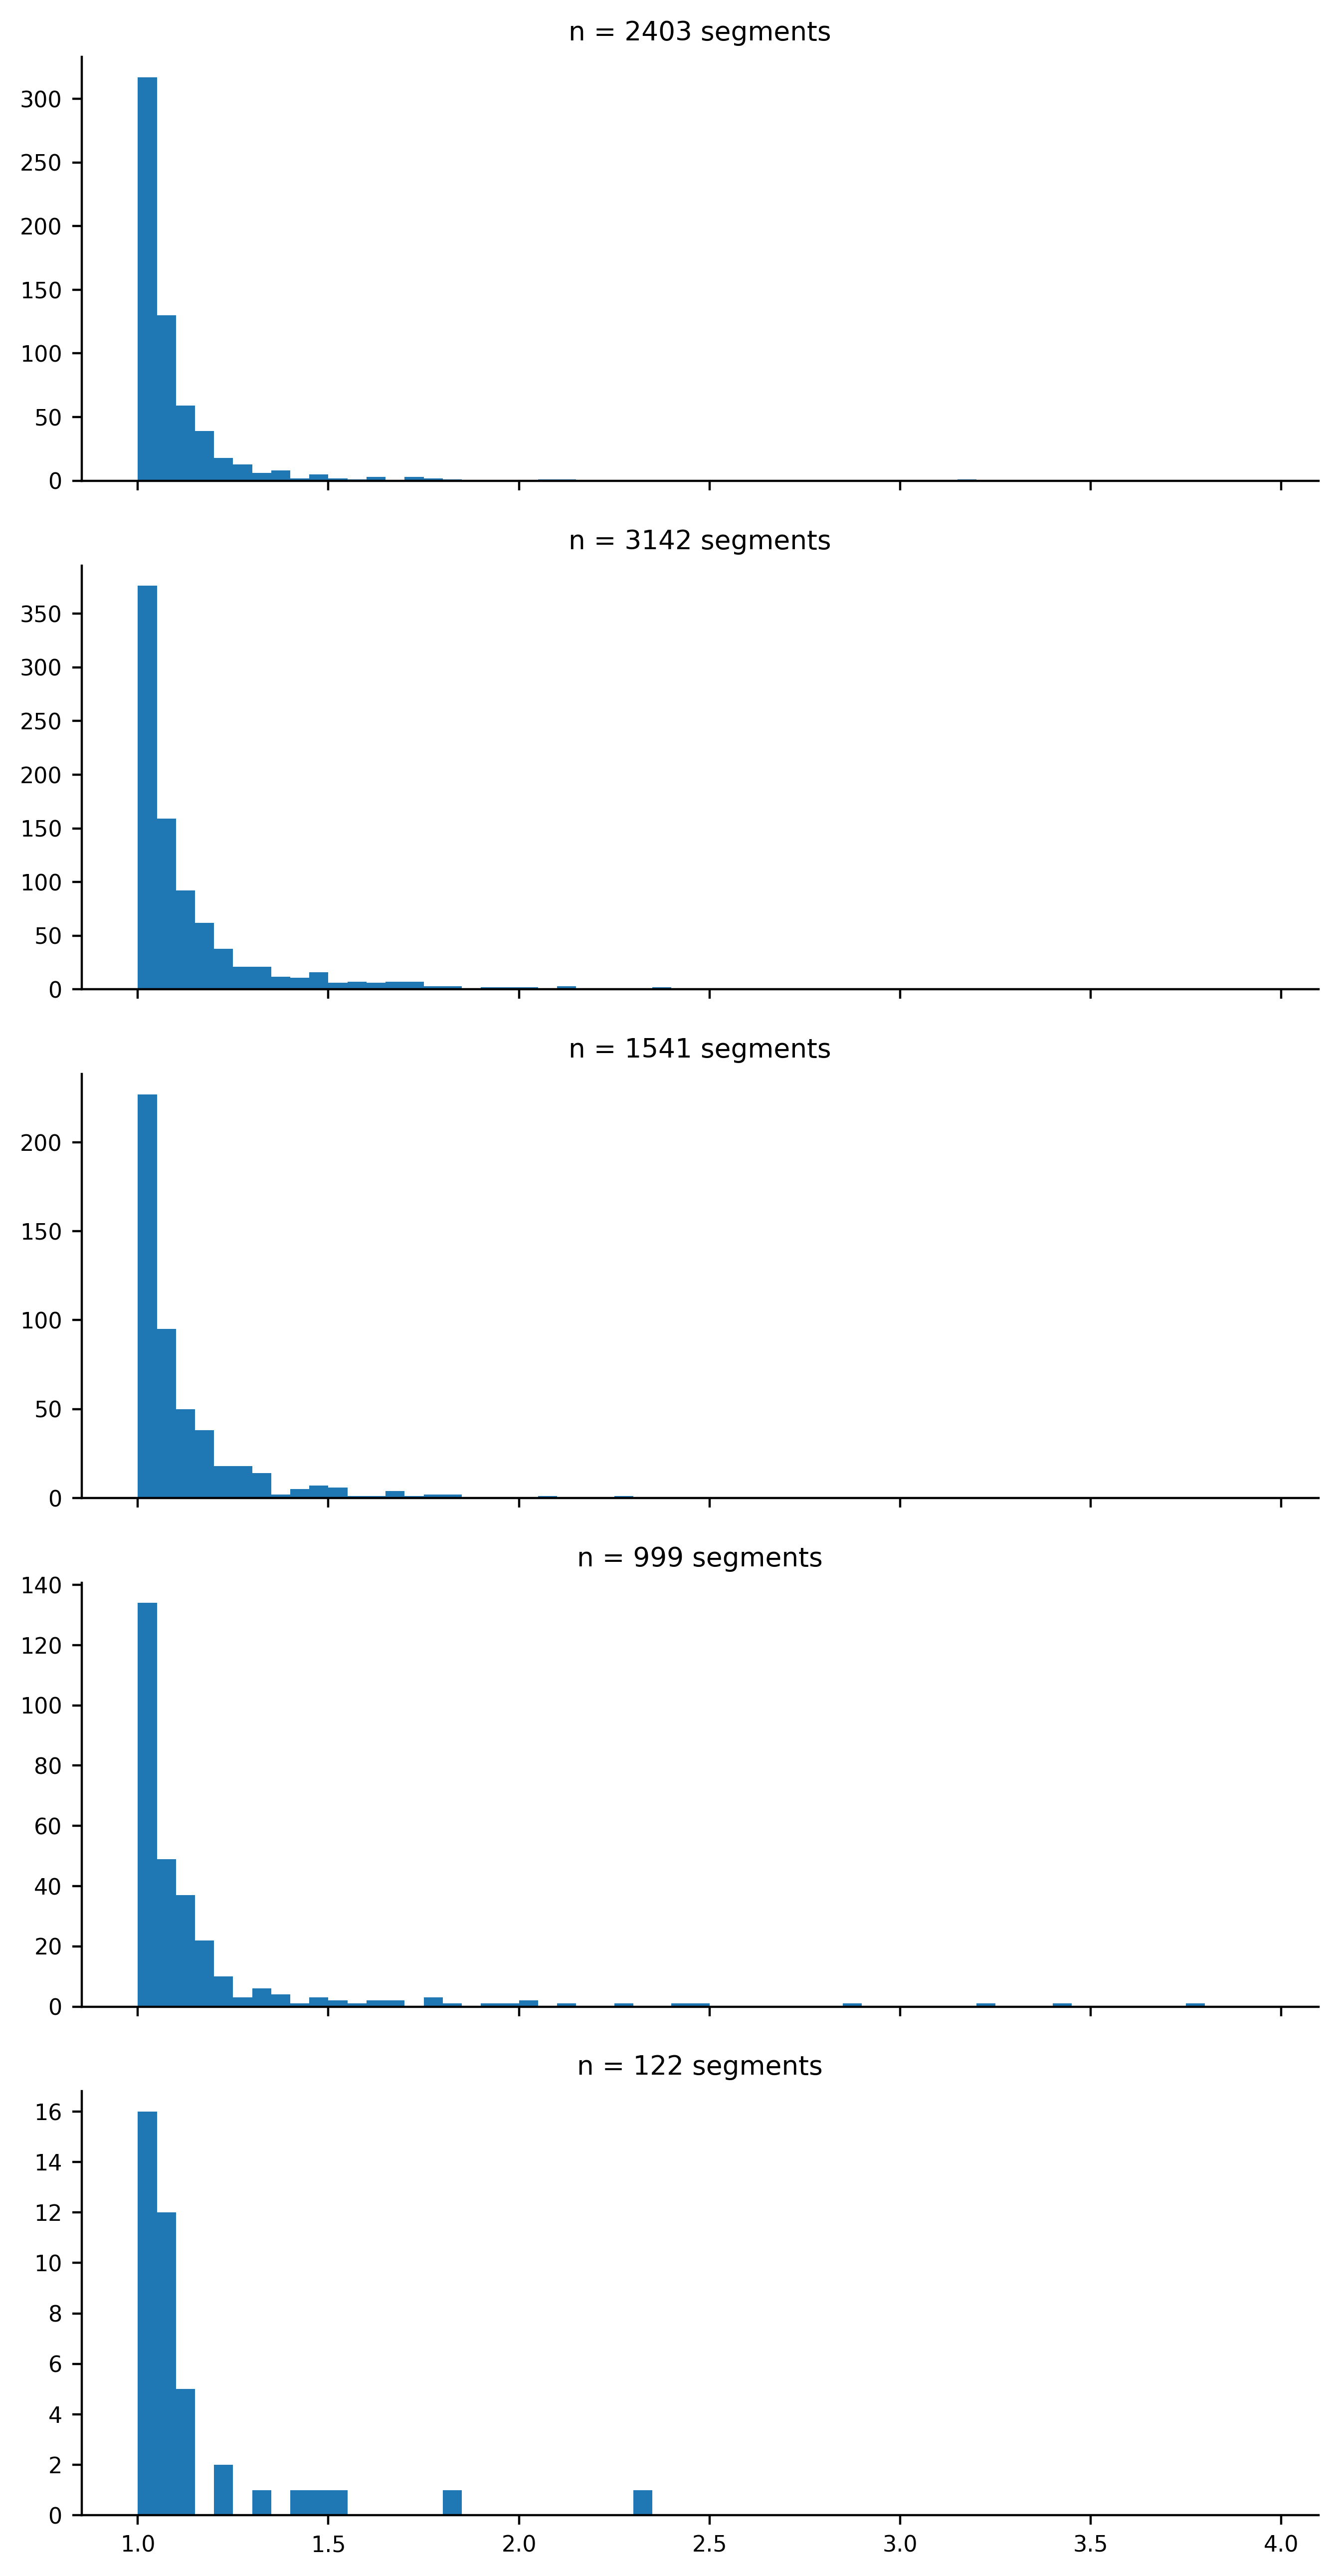

In [23]:
measure = 'tortuosity'
fig, axes = plt.subplots(5, sharex=True, figsize=[8, 16])
bins = np.arange(1.0, 4.0, 0.05)
i = 0
for st, segs in seg_df.groupby('subtype'):
    data = segs.loc[segs['strahl_ord'] > 1]
    axes[i].hist(data[measure].dropna().values, bins=bins)
    axes[i].set_title(f"n = {len(data)} segments")
    #axes[i,].hist(segs['len'].values)
    #axes[i, 2].hist(segs['strahl_ord'].values)
    i += 1
#     sns.histplot(segs, x='len', ax=axes[i, 1])
#     sns.histplot(segs, x='strahl_ord', ax=axes[i, 2])
    

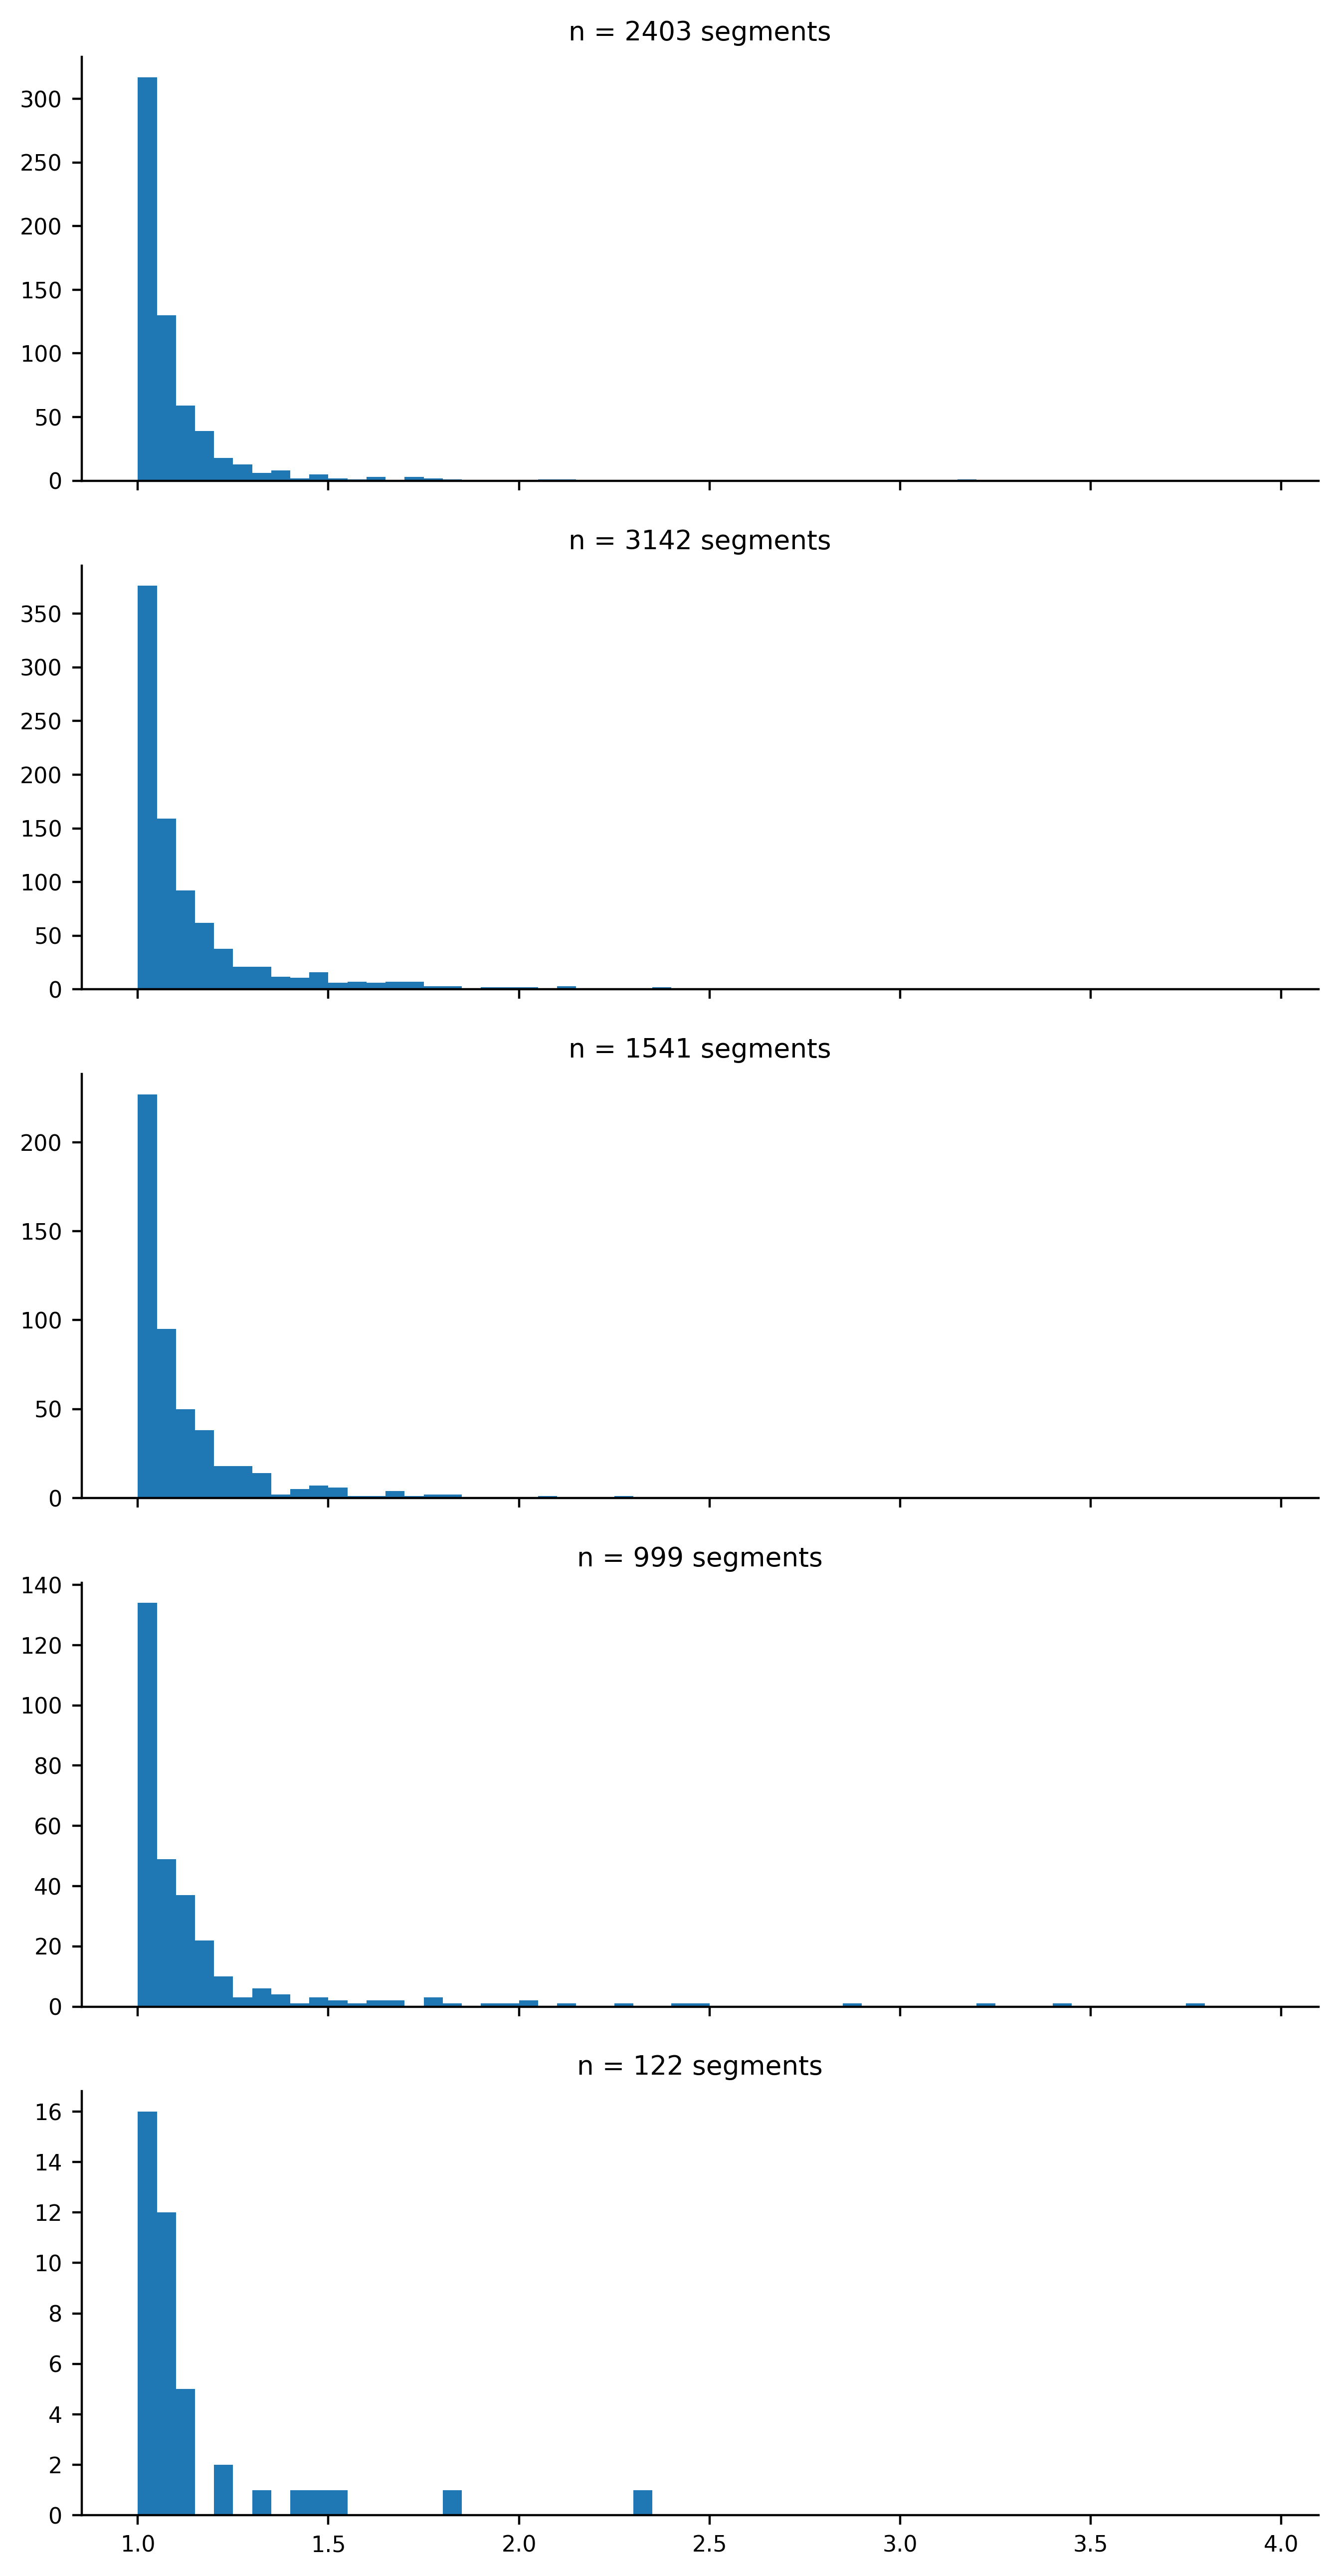

In [24]:
measure = 'tortuosity'
fig, axes = plt.subplots(5, sharex=True, figsize=[8, 16])
bins = np.arange(1.0, 4.0, 0.05)
i = 0
for st, segs in seg_df.groupby('subtype'):
    data = segs.loc[segs['strahl_ord'] > 1]
    axes[i].hist(data[measure].dropna().values, bins=bins)
    axes[i].set_title(f"n = {len(data)} segments")
    #axes[i,].hist(segs['len'].values)
    #axes[i, 2].hist(segs['strahl_ord'].values)
    i += 1
#     sns.histplot(segs, x='len', ax=axes[i, 1])
#     sns.histplot(segs, x='strahl_ord', ax=axes[i, 2])
    

In [ ]:
measure = 'len'
fig, axes = plt.subplots(5, sharex=True, figsize=[8, 16])
bins = np.arange(0.0, max(seg_df[measure]), 10)
i = 0
for st, segs in seg_df.groupby('subtype'):
    data = segs.loc[segs['strahl_ord'] > 1]
    axes[i].hist(data[measure].dropna().values, bins=bins)
    axes[i].set_title(f"n = {len(data)} segments")
    #axes[i,].hist(segs['len'].values)
    #axes[i, 2].hist(segs['strahl_ord'].values)
    i += 1
#     sns.histplot(segs, x='len', ax=axes[i, 1])
#     sns.histplot(segs, x='strahl_ord', ax=axes[i, 2])
    

In [ ]:
fig, axes = plt.subplots(5, sharex=True, figsize=[8, 16], sharey=True)

i = 0
for st, segs in seg_df.groupby('subtype'):
    n_bins = segs['strahl_ord'].max()
    axes[i].hist(segs['strahl_ord'].values, bins=n_bins)
    #axes[i,].hist(segs['len'].values)
    #axes[i, 2].hist(segs['strahl_ord'].values)
    i += 1

In [ ]:
fig, axes = plt.subplots(5, sharex=True, sharey=True, figsize=[8, 20])

i = 0
for st, segs in seg_df.groupby('subtype'):
    n_bins = segs['strahl_ord'].max()
    axes[i].scatter(x=segs['strahl_ord'], y=segs['len'])
    #axes[i,].hist(segs['len'].values)
    #axes[i, 2].hist(segs['strahl_ord'].values)
    i += 1